## 11. Transformix: Deformation Field and it's inverse

With the transformix algorithm the deformation field of the transformation, including it's inverse can be calculated.
The deformation field is a vector image where each voxel contains the displacement vector in physical coordinates.

### Elastix

In [1]:
# First two import are currently necessary to run ITKElastix on MacOs
from itk import itkElastixRegistrationMethodPython
from itk import itkTransformixFilterPython
import itk

In [2]:
# Import Images
fixed_image = itk.imread('data/CT_2D_head_fixed.mha', itk.F)
moving_image = itk.imread('data/CT_2D_head_moving.mha', itk.F)

# Import Default Parameter Map
parameter_object = itk.ParameterObject.New()
parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
parameter_object.AddParameterMap(parameter_map_rigid)

Registration with the registration function.
The output directory has to be specified, 
otherwise elastix will not save the transformparameter file as .txt file.

In [3]:
# Call registration function and specify output directory
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=parameter_object,
    output_directory='exampleoutput/')

### Transformix

In [4]:
# Import Image to transform, transformix is transforming from moving -> fixed;
# for this example the exact same moving image is used, this however is normally not 
# very usefull since the elastix algorithm already transformed this image.
moving_image_transformix = itk.imread('data/CT_2D_head_moving.mha', itk.F)

Transformation can either be done in one line with the transformix function...

In [5]:
transformed_image = itk.transformix_filter(
    moving_image=moving_image_transformix,
    transform_parameter_object=result_transform_parameters,
    compute_deformation_field=True,
    output_directory='exampleoutput/')

.. or by initiating an transformix image filter object.

In [11]:
# Load Transformix Object
transformix_object = itk.TransformixFilter.New()
transformix_object.SetMovingImage(moving_image_transformix)
transformix_object.SetTransformParameterObject(result_transform_parameters)

# Set advanced options
transformix_object.SetComputeDeformationField(True)

# Set output directory for spatial jacobian and its determinant,
# default directory is current directory.
transformix_object.SetOutputDirectory('exampleoutput/')

# Update object (required)
transformix_object.UpdateLargestPossibleRegion()

# Results of Transformation
result_image_transformix = transformix_object.GetOutput()
deformation_field = transformix_object.GetOutputDeformationField()

The deformation field can currently only be computed with the object oriented method of transformix, this will change is future updates to ITKElastix

## Deformation Field Inversion

The DisplacementMagnitudePenalty is a cost function that penalises ||Tµ(x) − x||2. You can use this
to invert transforms, by setting the transform to be inverted as an initial transform (using -t0), setting
(HowToCombineTransforms "Compose"), and running elastix with this metric, using the original fixed
image set both as fixed (-f) and moving (-m) image. After that you can manually set the initial transform
in the last parameter file to "NoInitialTransform", and voila, you have the inverse transform! Strictly
speaking, you should then also change the Size/Spacing/Origin/Index/Direction settings to match that of
the moving image.
Note that inverting a transformation becomes conceptually very similar to performing an image registration
in this way. Consequently, the same choices are relevant: optimisation algorithm, multiresolution etc...
With Transformix the inverted transform can then be used to calculate the inversion of the deformation field, just like Transformix normally calculates the deformation field from a transform.

In [12]:
# Import Default Parameter Map and adjust parameters
parameter_object = itk.ParameterObject.New()
parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
parameter_map_rigid['HowToCombineTransforms'] = ['Compose']
parameter_object.AddParameterMap(parameter_map_rigid)

# Call registration function with transform parameters of normal elastix run as initial transform
# on fixed image to fixed image registration.
inverse_image, inverse_transform_parameters = itk.elastix_registration_method(
    fixed_image, fixed_image,
    parameter_object=parameter_object,
    initial_transform_parameter_file_name='exampleoutput/TransformParameters.0.txt')

# Adjust inverse transform parameters object
inverse_transform_parameters.SetParameter(
    0, "InitialTransformParametersFileName", "NoInitialTransform")

In [13]:
# Load Transformix Object with inverse transform parameters
transformix_object = itk.TransformixFilter.New()

# Setting the original fixed image for inverse transformation should give the moving image as result
# but since we're focussed on obtaining the inverse deformation field, setting this image is trivial.
transformix_object.SetMovingImage(fixed_image)
transformix_object.SetTransformParameterObject(inverse_transform_parameters)

# Set Deformation Field boolean
transformix_object.SetComputeDeformationField(True)

# Update object (required)
transformix_object.UpdateLargestPossibleRegion()

# Get the inverse of the deformation field
inverse_deformation_field = transformix_object.GetOutputDeformationField()

### Visualization of the deformation field and its inverse.

In [14]:
import matplotlib.pyplot as plt
import numpy as np

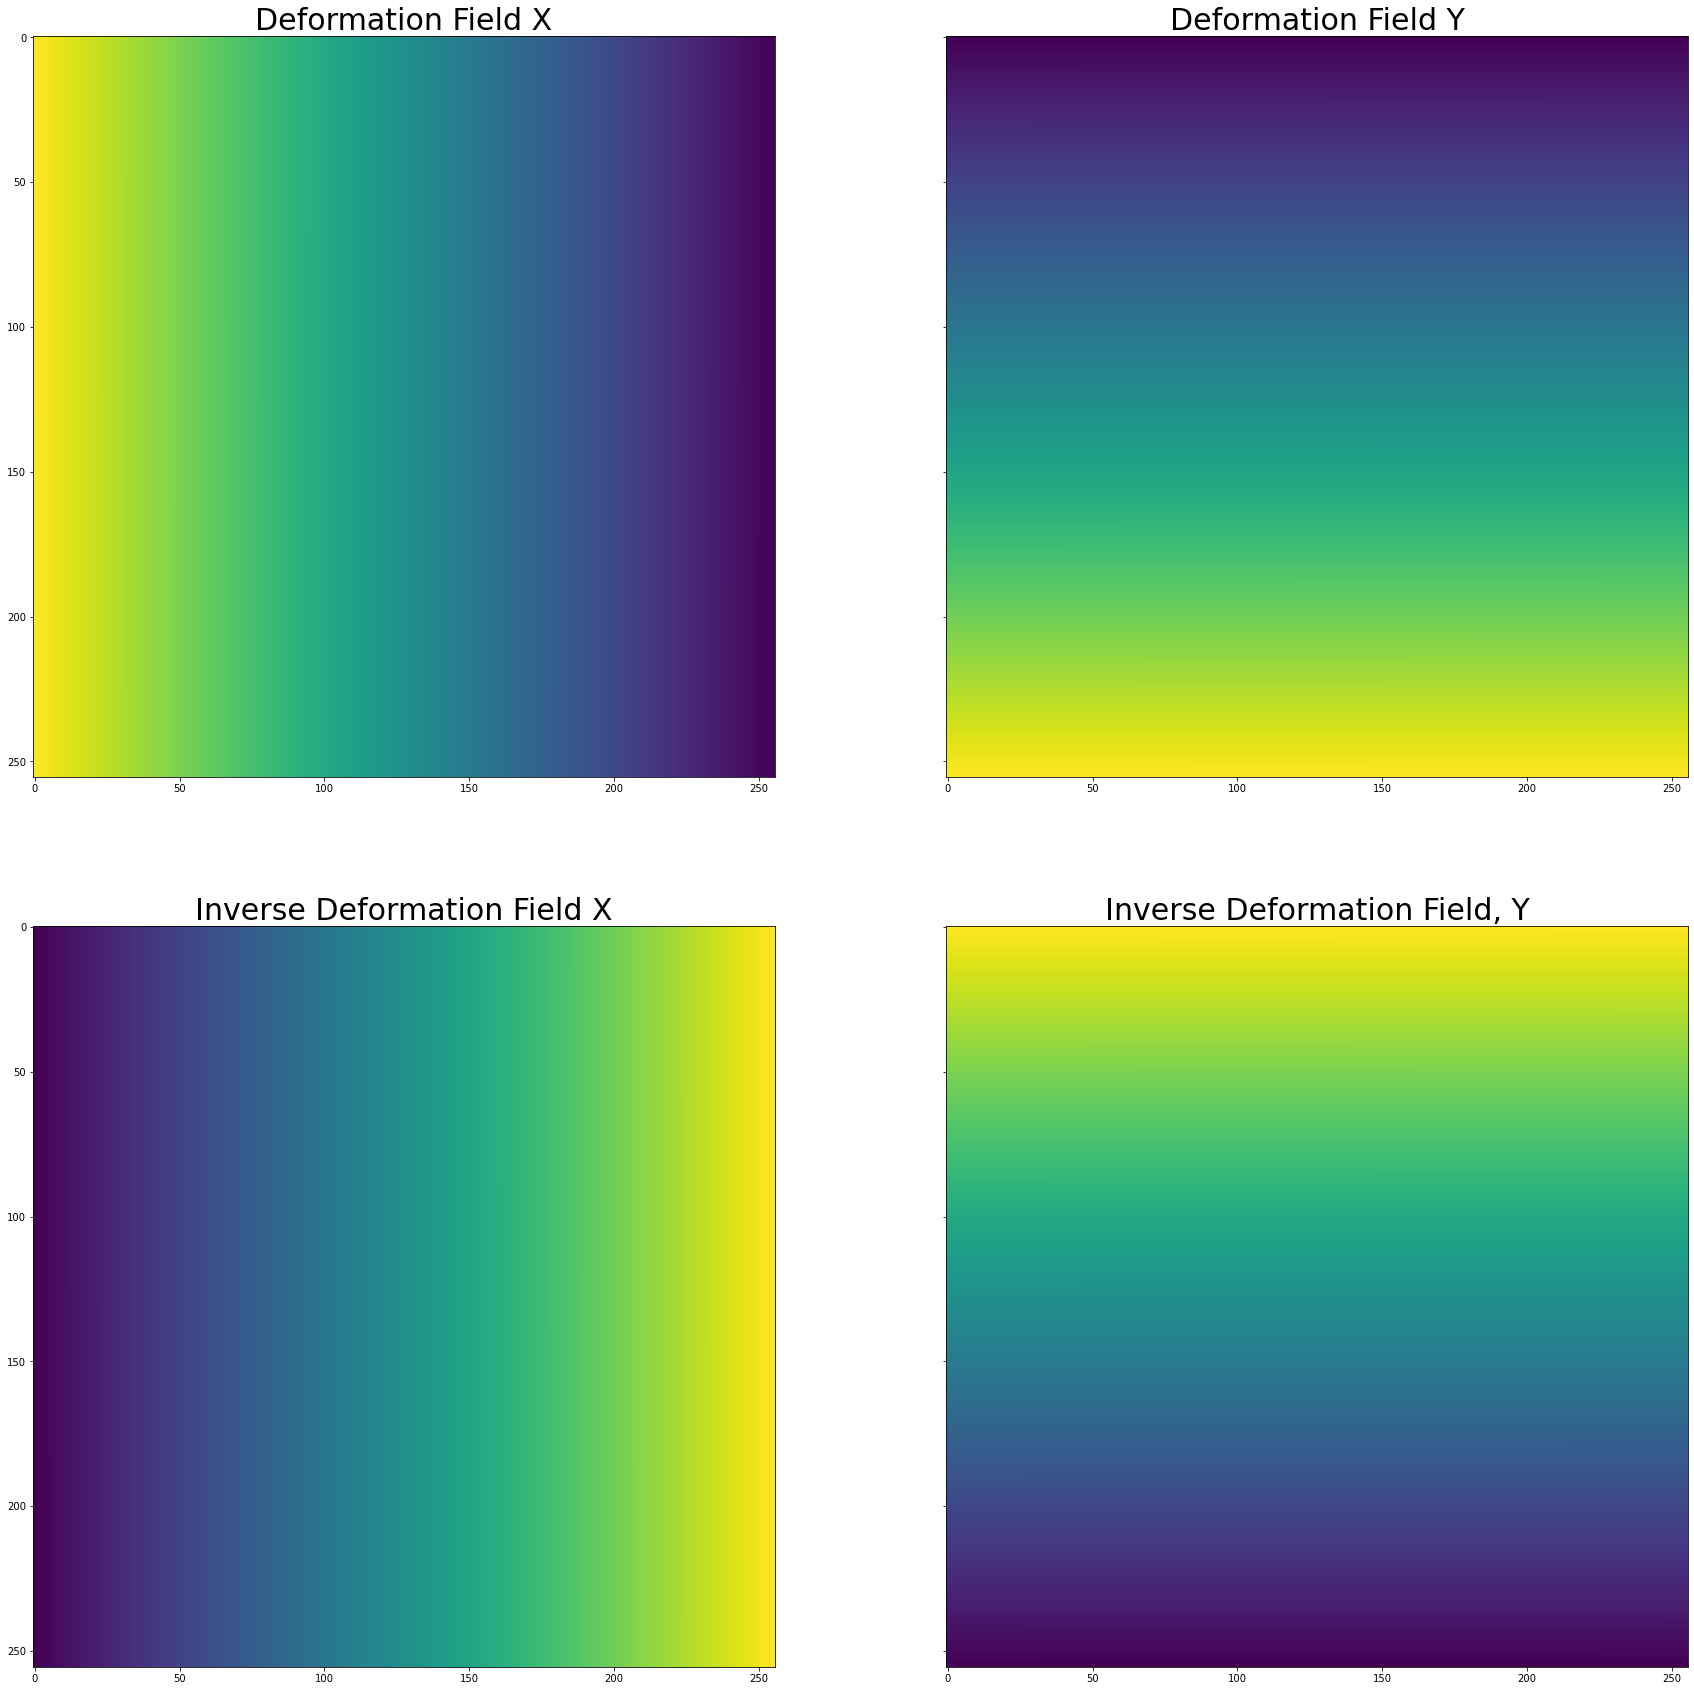

In [15]:
%matplotlib inline

deformation_field = np.asarray(deformation_field).astype(np.float32)
inverse_deformation_field = np.asarray(inverse_deformation_field).astype(np.float32)

# Plot images
fig, axs = plt.subplots(2,2, sharey=True, figsize=[30,30])
plt.figsize=[100,100]
axs[0,0].imshow(deformation_field[:,:,1])
axs[0,0].set_title('Deformation Field X', fontsize=30)
axs[0,1].imshow(deformation_field[:,:,0])
axs[0,1].set_title('Deformation Field Y', fontsize=30)
axs[1,0].imshow(inverse_deformation_field[:,:,1])
axs[1,0].set_title('Inverse Deformation Field X', fontsize=30)
axs[1,1].imshow(inverse_deformation_field[:,:,0])
axs[1,1].set_title('Inverse Deformation Field, Y', fontsize=30)
plt.show()